In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import scipy.stats as stats
%matplotlib inline
import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.activations import relu, softmax
import cv2
import keras.applications.imagenet_utils as imutils
import sklearn


In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train['image_id'] = df_train['image_id'] + '.jpg'
df_test['image_id'] = df_test['image_id'] +'.jpg'



In [3]:
print(df_train.head())
print(df_test.head())

      image_id  healthy  multiple_diseases  rust  scab
0  Train_0.jpg        0                  0     0     1
1  Train_1.jpg        0                  1     0     0
2  Train_2.jpg        1                  0     0     0
3  Train_3.jpg        0                  0     1     0
4  Train_4.jpg        1                  0     0     0
     image_id
0  Test_0.jpg
1  Test_1.jpg
2  Test_2.jpg
3  Test_3.jpg
4  Test_4.jpg


In [4]:
print(df_train.info())
print(df_test.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  1821 non-null   object
dtypes: object(1)
memory usage: 14.4+ KB
None


In [15]:

directory = 'images/'
img = []
for files in os.listdir(directory):
    if files.startswith('Train'):
        image = cv2.imread(directory+files)
        res = cv2.resize(image, (256,256))
        
        img.append(res)
    
img = np.array(img)
img.shape

(1821, 256, 256, 3)

In [17]:
train_labels = np.float32(df_train.loc[:,'healthy':'scab'].values)
train_labels

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [18]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(img)

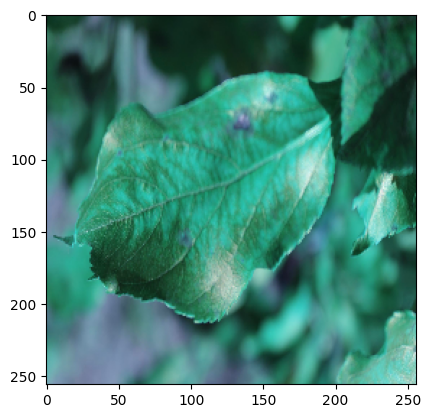

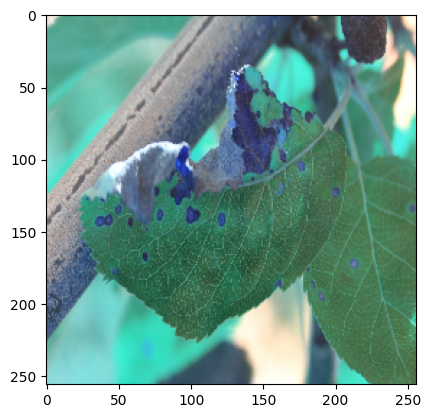

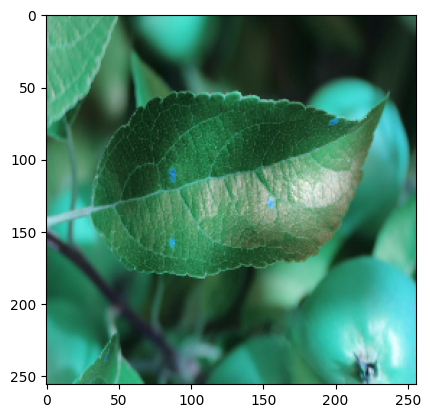

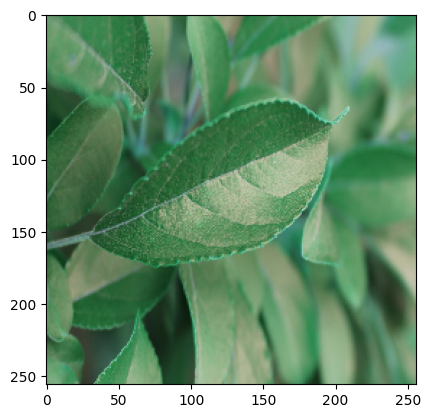

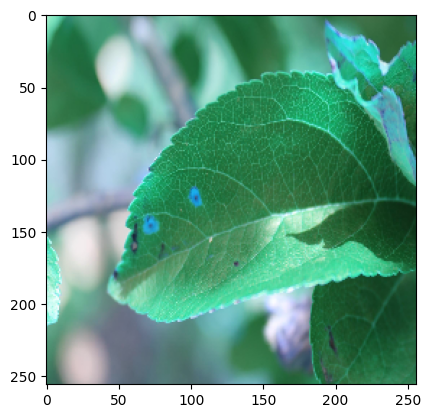

In [19]:
for i in range(0,5):
    plt.imshow(img[i])
    plt.show()

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(img, train_labels, test_size = 0.15)

In [32]:
from keras.applications.densenet import DenseNet121
from keras.models import Model
import keras
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from keras.layers import BatchNormalization

pretrained_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(256,256,3))
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')  
    ])
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss= tf.keras.losses.CategoricalCrossentropy(),
    metrics=['acc'] 

)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_4 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 7,045,700
Trainable params: 6,960,004
No

In [34]:
model.fit(  x_train, 
            y_train, 
            epochs=50,
            validation_split=0.2,
            callbacks=[ReduceLROnPlateau(monitor= 'val_acc', factor=0.2, patience=5, min_lr=0.000001)],
            use_multiprocessing=True
        )

Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 1.3819 - acc: 0.3444

TypeError: unhashable type: 'list'